<a href="https://colab.research.google.com/github/martinpius/MachineTranslation/blob/main/nanoGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from timeit import default_timer as timer
t1 = timer()
try:
  from google.colab import drive
  drive.mount("/content/drive/", force_remount = True)
  import torch
  from torch import nn, optim
  import torch.nn.functional as F
  from tqdm.auto import tqdm
  import matplotlib.pyplot as plt
  print(f">>>> You are in CoLaB with torch version: {torch.__version__}")
except Exception as e:
  print(f">>>> {type(e)}: {e}\n>>>> Please correct {type(e)} and reload")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f">>>> Available device: {device}")
BATCH_SIZE = 64 if device == torch.device("cuda") else 32
def mytimer(t: float = timer())->float:
  h = int(t / (60 * 60))
  m = int(t % (60 * 60) / 60)
  s = int(t % 60)
  return f"hrs: {h:04}, mins: {m:>02}, secs: {s:>05.2f}"
print(f">>>> Time elapsed \t {mytimer(timer() - t1)}")

Mounted at /content/drive/
>>>> You are in CoLaB with torch version: 2.0.1+cu118
>>>> Available device: cuda
>>>> Time elapsed 	 hrs: 0000, mins: 00, secs: 30.00


In [2]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open("input.txt", "r", encoding = "utf-8") as f:
  text = f.read()
print(f">>>> The first 1000 characters are:\n\n {text[:1000]}")

--2023-07-15 19:11:23--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2023-07-15 19:11:23 (55.9 MB/s) - ‘input.txt’ saved [1115394/1115394]

>>>> The first 1000 characters are:

 First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict

In [3]:
chars = sorted(list(set(text)))
voc_size = len(chars)
print(f">>>> There are {voc_size} unique characters in the dataset which are: {''.join(chars)}")

>>>> There are 65 unique characters in the dataset which are: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [4]:
stoi = {s: i for i, s in enumerate(chars)}
itos = {i: s for s, i in stoi.items()}
encode = lambda s: [stoi[i] for i in s]
decode = lambda l: "".join(itos[i] for i in l)
ts = "Hello, there!"
print(f">>>> When the text is : {ts}, The encoding is: {encode(ts)}")
print(f">>>> When the token indices are: {encode(ts)}: The text is: {decode(encode(ts))}")

>>>> When the text is : Hello, there!, The encoding is: [20, 43, 50, 50, 53, 6, 1, 58, 46, 43, 56, 43, 2]
>>>> When the token indices are: [20, 43, 50, 50, 53, 6, 1, 58, 46, 43, 56, 43, 2]: The text is: Hello, there!


In [5]:
n = int(len(text)*0.9)
data = torch.tensor(encode(text), dtype = torch.long)
train, dev = data[:n], data[n:]

In [6]:
# Hyperparameters
EPOCHS = 5000
max_eval_iters = 200
eval_iters = 500
LR = 3e-4
block_size = 256
embed_size = 384
n_heads = 6
n_layers = 6
dropout = 0.2

In [7]:
def get_data(split):
  data = train if split == "train" else dev
  ix = torch.randint(len(data) - block_size, (BATCH_SIZE,))
  xbatch = torch.stack([data[i : i + block_size] for i in ix])
  ybatch = torch.stack([data[i + 1: i + block_size + 1] for i in ix])
  xbatch, ybatch = xbatch.to(device), ybatch.to(device)
  return xbatch, ybatch
xbatch, ybatch = get_data("train")
print(f">>>> xbatch shape: {xbatch.shape}, ybatch shape: {ybatch.shape}")

for b in range(4):
  for t in range(block_size):
    context = xbatch[b, :t + 1]
    target = ybatch[b, t]
    #print(f">>>> When the context is {context}, the target is {target}")

>>>> xbatch shape: torch.Size([64, 256]), ybatch shape: torch.Size([64, 256])


In [8]:
class SelfAttention(nn.Module):

  def __init__(self, head_size)->None:
    super().__init__()
    self.q = nn.Linear(embed_size, head_size, bias = False)
    self.k = nn.Linear(embed_size, head_size, bias = False)
    self.v = nn.Linear(embed_size, head_size, bias = False)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

  def forward(self, x: torch.Tensor)->torch.Tensor:
    # x ==> output from embedding
    B, T, C = x.shape # shape ==> [BATCH_SIZE, block_size, embed_size]
    Q = self.q(x) # shape ==> [B, T, head_size]
    K = self.k(x)# shape ==> [B, T, head_size]
    V = self.v(x) # shape ==> [B, T, head_size]
    wei = Q @ K.transpose(-2, -1) * C**-0.5 # shape ==> [B, T, T] // scaled attention
    wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))
    wei = F.softmax(wei, dim = -1) # shape ==> [B, T, T]
    wei = self.dropout(wei)
    out = wei @ V # shape ==> [B, T, head_size == embed_size]
    return out


In [9]:
X = torch.randn(size = (BATCH_SIZE, block_size, embed_size), device = device)
attn = SelfAttention(embed_size).to(device = device)
print(f">>>> Output shape: {attn(X).shape}")

>>>> Output shape: torch.Size([64, 256, 384])


In [10]:
class MultiHead(nn.Module):

  def __init__(self, head_size, n_heads)->None:
    super().__init__()
    assert head_size == embed_size // n_heads
    self.multihead = nn.ModuleList([SelfAttention(head_size) for _ in range(n_heads)])
    self.projection = nn.Linear(embed_size, embed_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x: torch.Tensor)->torch.Tensor:
    h_out = torch.cat([h(x) for h in self.multihead], dim = -1)
    h_out = self.dropout(self.projection(h_out))
    return h_out


In [11]:
mld = MultiHead(embed_size // n_heads, n_heads).to(device)
print(f">>>> MultiHead attention output shape: {mld(X).shape}")

>>>> MultiHead attention output shape: torch.Size([64, 256, 384])


In [12]:
class Computations(nn.Module):

  def __init__(self, embed_size)->None:
    super().__init__()
    self.feednets = nn.Sequential(
        nn.Linear(embed_size, 4*embed_size),
        nn.ReLU(),
        nn.Linear(4*embed_size, embed_size),
        nn.Dropout(dropout))

  def forward(self, x: torch.Tensor)->torch.Tensor:
    # x output from multi-head attention [B, T, C]
    return self.feednets(x)

In [13]:
class TransformerBlock(nn.Module):

  def __init__(self, embed_size, n_heads)->None:
    super().__init__()
    head_size = embed_size // n_heads
    self.comm = MultiHead(head_size, n_heads)
    self.comp = Computations(embed_size)
    self.ln1 = nn.LayerNorm(embed_size)
    self.ln2 = nn.LayerNorm(embed_size)

  def forward(self, x: torch.Tensor)->torch.Tensor:
    x = x + self.comm(self.ln1(x))
    x = x + self.comp(self.ln2(x))
    return x


In [14]:
class NanoGPT(nn.Module):

  def __init__(self, voc_size, embed_size)->None:
    super().__init__()
    self.CatEmbedding = nn.Embedding(voc_size, embed_size)
    self.posEmbedding = nn.Embedding(block_size, embed_size)
    self.trf_blocks = nn.Sequential(*[TransformerBlock(embed_size, n_heads) for _ in range(n_layers)])
    self.ln = nn.LayerNorm(embed_size)
    self.fc = nn.Linear(embed_size, voc_size)

  def forward(self, x: torch.Tensor, target: torch.Tensor = None)->torch.Tensor:
    # x, target shapes ==> [B, block_size]==> context and target
    B, T = x.shape # unpacking the dimensions
    catEmb = self.CatEmbedding(x) # shape ==> [B, T = block_size, embed_size = C]
    pos = self.posEmbedding(torch.arange(T, device = device)) # shape ==> [block_size = T, embed_size = C]
    x = catEmb + pos # shape ==> [B, T, C]
    x = self.trf_blocks(x) # shape ==> [B, T, C]
    x = self.ln(x) # shape ==> [B, T, C]
    logits = self.fc(x) # shape ==> [B, T, C]

    if target is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits, target = logits.view(B*T, C), target.view(-1) # Reshapping for CE loss computation
      loss = F.cross_entropy(logits, target)
    return loss, logits

  def texts_generator(self, idx: torch.Tensor, max_tokens: int = 1000)->torch.Tensor:
    # idx is a current context with shape [B, T] same as input
    # max_tokens: maximum characters to generate
    for _ in range(max_tokens):
      idx_ = idx[:, -block_size:] # clipping to the max of block size only since we apppends new tokens
      loss, logits = self(idx_)
      logits = logits[:, -1,:] # shape ==> [B, C] Fetching the last time step== predicted token
      probs = F.softmax(logits, dim = -1) # Get the probs value for possibility of any token comming next [vocab_size in dim]
      idx_next = torch.multinomial(probs, num_samples = 1) # shape ==> [B, 1] # Selecting the index coresponding to the next token
      idx = torch.cat((idx, idx_next), dim = 1) # shape ==> [B, T + 1] appending the new char to the context and repeat the proc

    return idx



In [15]:
model = NanoGPT(voc_size, embed_size).to(device = device)
loss, logits = model(xbatch, ybatch)
print(f">>>> Logits shape: {logits.shape}, Loss for the untrained model: {loss:.4f}")
print(f">>>> Total number of trainable parameters in this model: {sum(p.numel() for p in model.parameters()):,}")

>>>> Logits shape: torch.Size([16384, 65]), Loss for the untrained model: 4.3161
>>>> Total number of trainable parameters in this model: 10,788,929


In [16]:
print(f">>>> Texts generated by the untrained nanoGPT:\n\n\
{''.join(decode(model.texts_generator(idx = torch.zeros(size = (1,1), dtype = torch.long, device = device))[0].tolist()))}")

>>>> Texts generated by the untrained nanoGPT:


.imuJV3bttKAz;Er;pyJk?APotb
WzLMI?LjKu3;QxVkB.Vj$WBAJf!gqkWv,iv'ay;B; TlVP.nGC:Rhb-V$W.k?.kPexvn!QQJQ$,&n?ghRWzEKgta.btGy:c'prJt;tIMQVHUaGIh&GRaOd$haMswPFdAt
,By3aCaKI:D&Qy;Ce S-?i$kaNUa'mguEN;bZoEZNEgf
na&XxyK,3pGnndrYdIco?:YWuCgCjeZ,DAtqsIk3DsDZ,hLHVJNkzRdvJW,MmAl3rcb.ruA-EYCG-gyhKG IBARgQJLIUAFPy$:$Zvm
TyQshoiH&XVnv!Vy&A?.rPWQvN$o
d. AB!HLZQvBL;','
VyNl'xi.uehazCLIov r3!tN$YjW!I
Jj$RGw;yGdvtIvf&Fe cRC-BJaO.QSHAypSd:YLoH;l;.PGSgCPdgZlyLpWgtZCABhtJtFce$xEnLIKggesFgV
m'QdyPsLHp!ZIw$ws.hRsYyNFKxh;ALNs ZnL U!twTJt!zbdSvRLIVEwvoB!m!s,KAv3
IFlFgmkGQA:dpktWs,AoeEcGB;.Xg
v;A ?uHQZABVIBIQbGyg,TE&SzdIa!nO
Clh-FpA,'wPN pV3CrfAB
TirR?hB; IAQYgAIs'WWIN:GJ?'
viNp?l
d$pvbv$tIL!O',rSpo,VxnO.?ydInTPC$td;l!sLI3dwGke'URGHPBATCd'pVnrzgZz'hv3vHZIEYJzBQL3tvITEmhqC?igrladHLH?nn !LU PhATZgaZhov

pGAASmI;Cp
k.Rd?N&mWW,ZCPyeeIJ3QfxSVQta.?dKv!,V tDtSdqjAgqA!GcB:GXpYeZGJJLId;Q,Q'-;v$isWpTAIWchTj.!T:q:n;y$yeqQ$ku;LuUxb;AQVxC!ddEQgTenEBbYuNNFgQ!LAGzWpkMvPJ3 ;yTeUA 

In [17]:
@torch.no_grad()
def estimate_loss():
  out = {}
  model.eval()
  for split in ["train", "eval"]:
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      x, y = get_data(split)
      loss, logits = model(x, y)
      losses[k] = loss.item()
    out[split] = losses.mean()
  model.train()
  return out

In [18]:
tic = timer()
losses = []
steps = []
optimizer = optim.AdamW(params = model.parameters(), lr = LR)

  0%|          | 0/5000 [00:00<?, ?it/s]

>>>> End of epoch 1: Evaluation loss on the training data: 4.3191    Evaluation loss on validation data: 4.3273
>>>> Epoch 1: Train Loss: 4.3185
>>>> Epoch 100: Train Loss: 2.4927
>>>> End of epoch 200: Evaluation loss on the training data: 2.4177    Evaluation loss on validation data: 2.4390
>>>> Epoch 200: Train Loss: 2.4479
>>>> Epoch 300: Train Loss: 2.3606
>>>> End of epoch 400: Evaluation loss on the training data: 2.1404    Evaluation loss on validation data: 2.1889
>>>> Epoch 400: Train Loss: 2.1891
>>>> Epoch 500: Train Loss: 2.0967
>>>> End of epoch 600: Evaluation loss on the training data: 1.8888    Evaluation loss on validation data: 1.9994
>>>> Epoch 600: Train Loss: 1.9628
>>>> Epoch 700: Train Loss: 1.8693
>>>> End of epoch 800: Evaluation loss on the training data: 1.7148    Evaluation loss on validation data: 1.8592
>>>> Epoch 800: Train Loss: 1.7701
>>>> Epoch 900: Train Loss: 1.7412
>>>> End of epoch 1000: Evaluation loss on the training data: 1.5962    Evaluation l

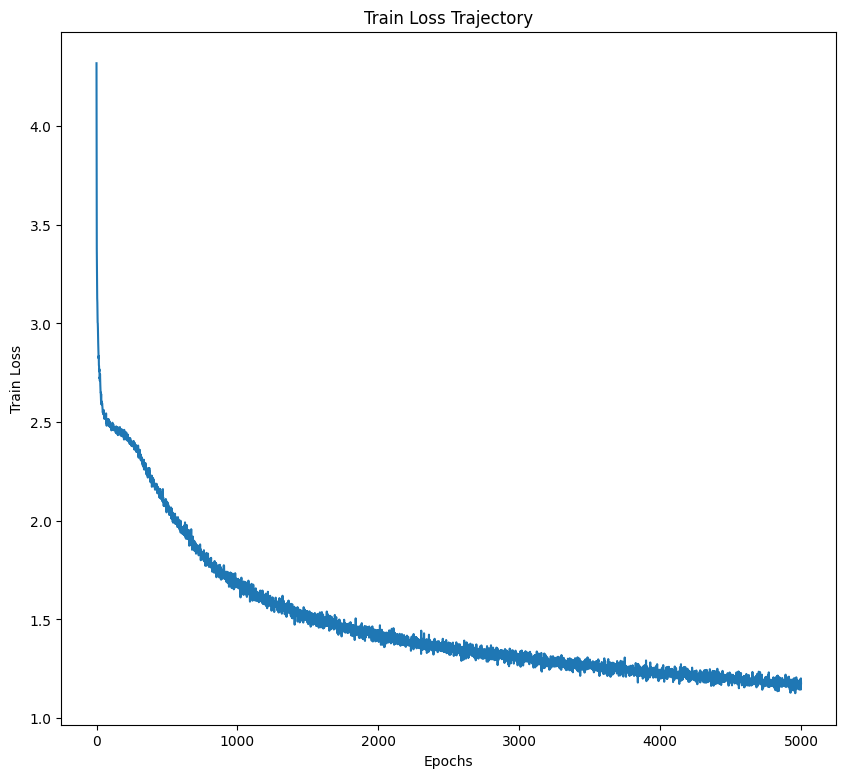

In [19]:
for epoch in tqdm(range(EPOCHS)):
  if epoch % max_eval_iters == 0:
    out = estimate_loss()
    print(f">>>> End of epoch {epoch + 1 if epoch == 0 else epoch}: Evaluation loss on the training data: {out['train']:.4f}\
    Evaluation loss on validation data: {out['eval']:.4f}")
  # Training our nonoGPT model
  x, y = get_data("train")
  loss, logits = model(x, y)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if epoch % 100 == 0: print(f">>>> Epoch {epoch + 1 if epoch == 0 else epoch}: Train Loss: {loss:.4f}")
  steps.append(epoch)
  losses.append(loss.item())

plt.figure(figsize = (10, 9))
plt.plot(steps, losses)
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.title("Train Loss Trajectory")
toc = timer()
print(f"\n\n>>>> Total time elapsed: {mytimer(toc - tic)}")

In [21]:
print(f">>>> Texts generated by the trained nanoGPT:\n\n\
{''.join(decode(model.texts_generator(idx = torch.zeros(size = (1,1), dtype = torch.long, device = device),max_tokens =5000)[0].tolist()))}")

>>>> Texts generated by the trained nanoGPT:



Second Messenger:
Yes, well; I'll tell thee resport then.

First Watchman:
What is the bell? Away her stander?

First Watchman:
When for give her with your dreadful serve?

Page:
Down to Lambert made inch silvents as the esteement,
Or holds as good and galling to fetce the porl.

KING EDWARD IV:
It is 'twill'd with a pardon.

YORK:
You dear'st nothing?

HENRY BOLINGBROKE:
What say we this, what was with ily bolt?

BUSWY:
What calls?

CHRSCY:

KING HENRY VI:
A reposet, Sir John, and the Geet
They are, this mast subscrifice with age heart.

WESTMORELAND:
To the king when the Angelo kils them fortune welcome.

CLIFFORD:
Why are this triber be surbs, provost of noble worse?

LEONTES:
Allong comes thing I am not welcome,--
We'll set the king in this notice by things againstard,
Which short by overwhale: seeign not in free
Break the struty from happy of blood,
To all grosits and content time
Even like viold, themselves that spoke me with me.

N